# Quick Visualize on simulated data
This part is for quick visualization of my simulation result (without re-run the whole simulation).

Important parameters of the data used to produce plots:
1. toyMC: 10M positron events
2. musrSim: 10 M positron events

    positron settings used in musrSim macro:
```
/gun/primaryparticle mu+
/gun/vertex 0 0 0 mm
/gun/momentum 0 MeV
/gun/muonPolarizVector 0 0 0
```


3. gm2ringsim: 5M positron events (dataset: gm2ringsim_muon_gasgun_ana_21378178_1.root)


Note: For quick visualization, I compressed all dataset into a small file hist_dict.npy that contains just enough information to reproduce the plots.

In [1]:
import ROOT as r
import math
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/00


# load and compress data

In [2]:
# load MC data
Michel_Samples = np.load('./data/01_michel_samples_10M.npy') # MAX_LOOP=Michel_Samples.shape[0]
four_momenta_mu_frame = np.load('./data/02_four_momenta_MRF_10M.npy')
four_momenta_LAB = np.load('./data/03_four_momenta_LAB_10M.npy')

In [3]:
# load musrSim data
df = r.RDataFrame("t1",'../10M_data/musr_10Mv2.root')
df = df.Define("posiInitE","sqrt(posIniMomX*posIniMomX + posIniMomY*posIniMomY + posIniMomZ*posIniMomZ - 0.511*0.511)")
musrSim_dict = df.AsNumpy()

In [4]:
r.gInterpreter.Declare("""
//#include <math.h>

double Phase(double y1, double x1, double y2, double x2) {
   /* compute the angle difference between vector1 and vector2 given their x,y components. */
   
   double ans1 = atan2(y1,x1);  //angle of vector 1, muDecayP
   double ans2 = atan2(y2,x2);  //angle of vector 2, muDecayPol
   double ans = ans1 - ans2;
   
   if(ans<0){
       ans = ans+2*M_PI;
    }
       
   return ans;
}
""")

# load gm2ringsim data
fname = "/home/junkai.ng/junkai.ng/CaloMC/gm2ringsim_muon_gasgun_ana_21378178_1.root"
df = r.RDataFrame("G2PhaseAnalyzer/g2phase",fname)
df = df.Define("g2phase", "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)") 
df = df.Define("cosg2phase", "cos(g2phase)") 
varList = ["posiInitE","posiInitPX","posiInitPY","posiInitPZ","g2phase","cosg2phase"]
data_gm2ringsim = df.AsNumpy(columns=varList)

ReadStreamerInfo, class:string, illegal uid=-2


Warning in <TClass::Init>: no dictionary for class __basic_string_common<true> is available


In [5]:
# cut michel spectrum at different ctheta
michel_cut_ctheta1 = Michel_Samples[abs(Michel_Samples[:,1]-1)<=0.5] # ctheta= 1, theta=0
michel_cut_ctheta0 = Michel_Samples[abs(Michel_Samples[:,1])<=0.5]   # ctheta= 0, theta=90
michel_cut_ctheta_1 = Michel_Samples[abs(Michel_Samples[:,1]+1)<=0.5] # ctheta= -1, theta=180

In [6]:
# sort out data at different cos(g2phase), for sampled data
filter1 = np.where(abs(four_momenta_LAB[:,9]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(four_momenta_LAB[:,9])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(four_momenta_LAB[:,9]+1)<=0.4 ) # ctheta= -1

four_momenta_lab_filter_1 = four_momenta_LAB[filter1]
four_momenta_lab_filter_2 = four_momenta_LAB[filter2]
four_momenta_lab_filter_3 = four_momenta_LAB[filter3]

In [7]:
# sort out data at different cos(g2phase), for gm2ringsim data
data_gm2ringsim_partial = np.zeros(shape=(2,data_gm2ringsim["posiInitE"].size))
data_gm2ringsim_partial[0] = data_gm2ringsim["posiInitE"]
data_gm2ringsim_partial[1] = data_gm2ringsim["cosg2phase"]
data_gm2ringsim_partial = data_gm2ringsim_partial.T

filter1 = np.where(abs(data_gm2ringsim_partial[:,1]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(data_gm2ringsim_partial[:,1])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(data_gm2ringsim_partial[:,1]+1)<=0.4 ) # ctheta= -1

data_gm2ringsim_partial_filter_1 = data_gm2ringsim_partial[filter1]
data_gm2ringsim_partial_filter_2 = data_gm2ringsim_partial[filter2]
data_gm2ringsim_partial_filter_3 = data_gm2ringsim_partial[filter3]

In [8]:
# sort out data at different MRF energy cut
filter4 = np.where(four_momenta_mu_frame[:,0]>=1 )
filter5 = np.where(four_momenta_mu_frame[:,0]>=5 )
filter6 = np.where(four_momenta_mu_frame[:,0]>=10 )

four_momenta_lab_filter_4 = four_momenta_LAB[filter4]
four_momenta_lab_filter_5 = four_momenta_LAB[filter5]
four_momenta_lab_filter_6 = four_momenta_LAB[filter6]

In [9]:
# save all histogram bin information
hist_dict = {}

# MC michel spectrum
hist_dict['michel_x'] = np.histogram(Michel_Samples[:,0],bins=50,range=(0,1),density=True)
hist_dict['michel_ctheta'] = np.histogram(Michel_Samples[:,1],bins=50,density=True)
hist_dict['michel_cut_ctheta1'] = np.histogram(michel_cut_ctheta1[:,0],bins=50,density=True)
hist_dict['michel_cut_ctheta0'] = np.histogram(michel_cut_ctheta0[:,0],bins=50,density=True)
hist_dict['michel_cut_ctheta_1'] = np.histogram(michel_cut_ctheta_1[:,0],bins=50,density=True)


# MRF distribution: toyMC vs musrSim
hist_dict['mrf_E_mc'] = np.histogram(four_momenta_mu_frame[:,0],range=(0,52.8),bins=50,density=True)
hist_dict['mrf_E_musr'] = np.histogram(musrSim_dict['posiInitE'],range=(0,52.8),bins=50,density=True)

hist_dict['mrf_PX_mc'] = np.histogram(four_momenta_mu_frame[:,1],range=(-52.8,52.8),bins=50,density=True)
hist_dict['mrf_PX_musr'] = np.histogram(musrSim_dict['posIniMomX'],range=(-52.8,52.8),bins=50,density=True)

hist_dict['mrf_PY_mc'] = np.histogram(four_momenta_mu_frame[:,2],range=(-52.8,52.8),bins=50,density=True)
hist_dict['mrf_PY_musr'] = np.histogram(musrSim_dict['posIniMomY'],range=(-52.8,52.8),bins=50,density=True)

hist_dict['mrf_PZ_mc'] = np.histogram(four_momenta_mu_frame[:,3],range=(-52.8,52.8),bins=50,density=True)
hist_dict['mrf_PZ_musr'] = np.histogram(musrSim_dict['posIniMomZ'],range=(-52.8,52.8),bins=50,density=True)


# LAB distribution: toyMC vs musrSim
hist_dict['E_mc'] = np.histogram(four_momenta_LAB[:,0],range=(0,3100),bins=50,density=True)
hist_dict['E_gm2ringsim'] = np.histogram(data_gm2ringsim['posiInitE'],range=(0,3100),bins=50,density=True)

hist_dict['PX_mc'] = np.histogram(four_momenta_LAB[:,1],range=(-3100,3100),bins=50,density=True)
hist_dict['PX_gm2ringsim'] = np.histogram(data_gm2ringsim['posiInitPX'],range=(-3100,3100),bins=50,density=True)

hist_dict['PY_mc'] = np.histogram(four_momenta_LAB[:,2],range=(-56,56),bins=50,density=True)
hist_dict['PY_gm2ringsim'] = np.histogram(data_gm2ringsim['posiInitPY'],range=(-56,56),bins=50,density=True)

hist_dict['PZ_mc'] = np.histogram(four_momenta_LAB[:,3],range=(-3100,3100),bins=50,density=True)
hist_dict['PZ_gm2ringsim'] = np.histogram(data_gm2ringsim['posiInitPZ'],range=(-3100,3100),bins=50,density=True)


# plot of 3 different g2phases
hist_dict['cos1_mc'] = np.histogram(data_gm2ringsim_partial_filter_1[:,0],range=(-3100,3100),bins=60,density=True)
hist_dict['cos1_gm2ringsim'] = np.histogram(four_momenta_lab_filter_1[:,0],range=(-3100,3100),bins=60,density=True)

hist_dict['cos0_mc'] = np.histogram(data_gm2ringsim_partial_filter_2[:,0],range=(-3100,3100),bins=60,density=True)
hist_dict['cos0_gm2ringsim'] = np.histogram(four_momenta_lab_filter_2[:,0],range=(-3100,3100),bins=60,density=True)

hist_dict['cos-1_mc'] = np.histogram(data_gm2ringsim_partial_filter_3[:,0],range=(-3100,3100),bins=60,density=True)
hist_dict['cos-1_gm2ringsim'] = np.histogram(four_momenta_lab_filter_3[:,0],range=(-3100,3100),bins=60,density=True)


# phase vs E
hist_dict['phaseVsE_mc'] = np.histogram2d(four_momenta_LAB[:,8],four_momenta_LAB[:,0],bins=(35,35),density=True)
hist_dict['phaseVsE_gm2ringsim'] = np.histogram2d(data_gm2ringsim['g2phase'],data_gm2ringsim['posiInitE'],bins=(35,35),density=True)


# Energy: mrf vs lab
hist_dict['E_mrf_v_lab'] = np.histogram2d(four_momenta_mu_frame[:,0],four_momenta_LAB[:,0],bins=(35,35),density=True)


# Energy: mrf vs lab with different mrf energy cut
hist_dict['Elab_mrfcut_1mev'] = np.histogram(four_momenta_lab_filter_4[:,0],bins=50,density=True)
hist_dict['Elab_mrfcut_5mev'] = np.histogram(four_momenta_lab_filter_5[:,0],bins=50,density=True)
hist_dict['Elab_mrfcut_10mev'] = np.histogram(four_momenta_lab_filter_6[:,0],bins=50,density=True)


np.save('hist_dict.npy',hist_dict)

https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html

https://stackoverflow.com/questions/40219946/python-save-dictionaries-through-numpy-save

# Visualize data

In [10]:
# load histograms data
hist_dict = np.load('hist_dict.npy',allow_pickle=True).item()

# 1.0 Michel Spectrum : toyMC vs theoretical calculations

taken from: IntroductoryMuonScience-Nagamine p.12

all the following equations are for decay positrion,

$${E_e}^2(3E_m-2E_e)[1-A(E_e)\cos \theta] $$

$$A(E_e) = \frac{E_m - 2E_e}{3E_m-2E_e}$$

$$\propto x^2[(3-2x)-(1-2x)\cos \theta]$$

integrated over all $\theta$ :

$$\propto x^2 ( 3-2x)$$

# 1.1 distribution over $x$ and $\theta$

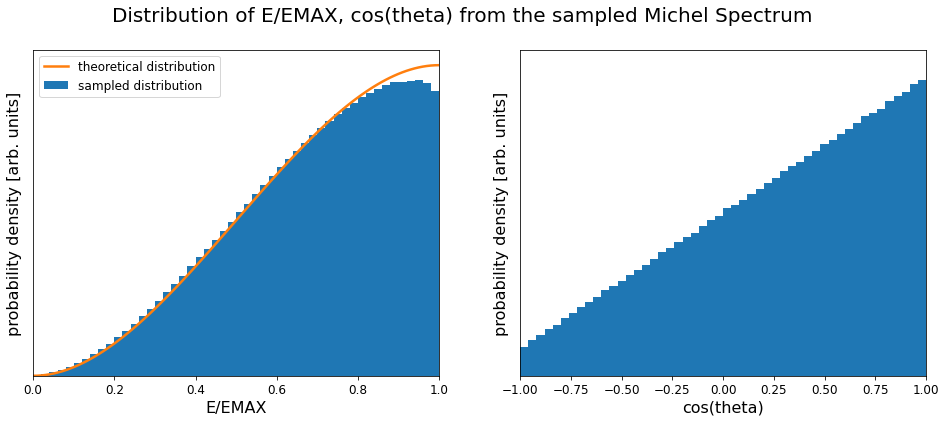

In [11]:
# retrieve histogram bins
michel_x = hist_dict.get('michel_x')
michel_ctheta = hist_dict.get('michel_ctheta')


# theoretical calculation
x = np.zeros(shape=(2,100))
x[0]=np.linspace(0.0,1.0,100) # exclude the endpoint to prevent integral blows up !

y = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x[1] = y(x[0])
x[1] = x[1]/np.mean(x[1]) # dividing a distribution with its mean is p.d.f


# plot
plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(16,6))
fig.suptitle('Distribution of E/EMAX, cos(theta) from the sampled Michel Spectrum ', fontsize=20)

ax1 = fig.add_subplot(1,2,1)
ax1.hist(x=michel_x[1][:-1],bins=michel_x[1],weights=michel_x[0], stacked=True,label='sampled distribution') # density:normalized
ax1.plot(x[0],x[1],linewidth=2.5,label='theoretical distribution')
ax1.set_xlim([0,1])
ax1.set_yticklabels([])
ax1.set_xlabel('E/EMAX',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(1,2,2)
ax2.hist(x=michel_ctheta[1][:-1],bins=michel_ctheta[1],weights=michel_ctheta[0])
ax2.set_xlim([-1,1])
ax2.set_ylim([0.3,0.7])
ax2.set_yticklabels([])
ax2.set_xlabel('cos(theta)',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='y', left=False)
ax2.tick_params(axis='x', labelsize=12)

# 1.2 Michel spectrum for $\theta$ = 0 , 90 ,180

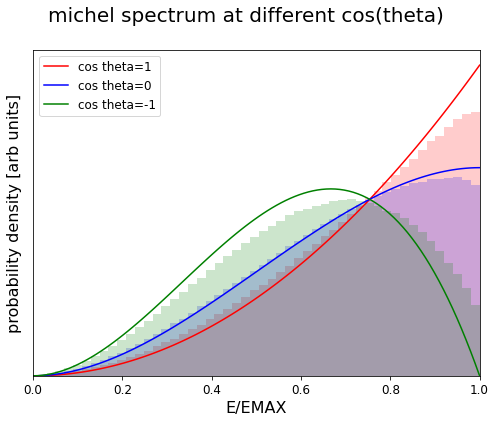

In [12]:
# retrieve histogram bins
michel_cut_ctheta1 = hist_dict.get('michel_cut_ctheta1')
michel_cut_ctheta0 = hist_dict.get('michel_cut_ctheta0')
michel_cut_ctheta_1 = hist_dict.get('michel_cut_ctheta_1')


# compare with theoretical calculation
x = np.zeros(shape=(5,100))
x[0]=np.linspace(0.0,1.0,100) # exclude the endpoint to prevent integral blows up !

y2 = lambda x,ctheta: x*x*((3-2*x)-(1-2*x)*ctheta) # IntroductoryMuonScience-Nagamine fig1.6 full formula
x[1] = y2(x[0],1)
x[1] = x[1]/np.mean(x[1]) 

x[2] = y2(x[0],0)
x[2] = x[2]/np.mean(x[2]) 

x[3] = y2(x[0],-1)
x[3] = x[3]/np.mean(x[3]) 

y1 = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x[4] = y1(x[0])
x[4] = x[4]/np.mean(x[4]) 


# plot
plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(8,6))
fig.suptitle('michel spectrum at different cos(theta) ', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(x=michel_cut_ctheta1[1][:-1],bins=michel_cut_ctheta1[1],weights=michel_cut_ctheta1[0], alpha=0.2,color='red')
ax1.plot(x[0],x[1],color='red',label='cos theta=1')

ax1.hist(x=michel_cut_ctheta0[1][:-1],bins=michel_cut_ctheta0[1],weights=michel_cut_ctheta0[0], alpha=0.2,color='blue')
ax1.plot(x[0],x[2],color='blue',label='cos theta=0')

ax1.hist(x=michel_cut_ctheta_1[1][:-1],bins=michel_cut_ctheta_1[1],weights=michel_cut_ctheta_1[0], alpha=0.2,color='green')
ax1.plot(x[0],x[3],color='green',label='cos theta=-1')

ax1.legend(fontsize=12)
ax1.set_xlim([0,1])
ax1.set_xlabel('E/EMAX',fontsize=16)
ax1.set_ylabel("probability density [arb units]",fontsize=16)
ax1.set_yticklabels([])
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)

# 2.1 E, PX, PY ,PZ (in MRF): toyMC vs musrSim

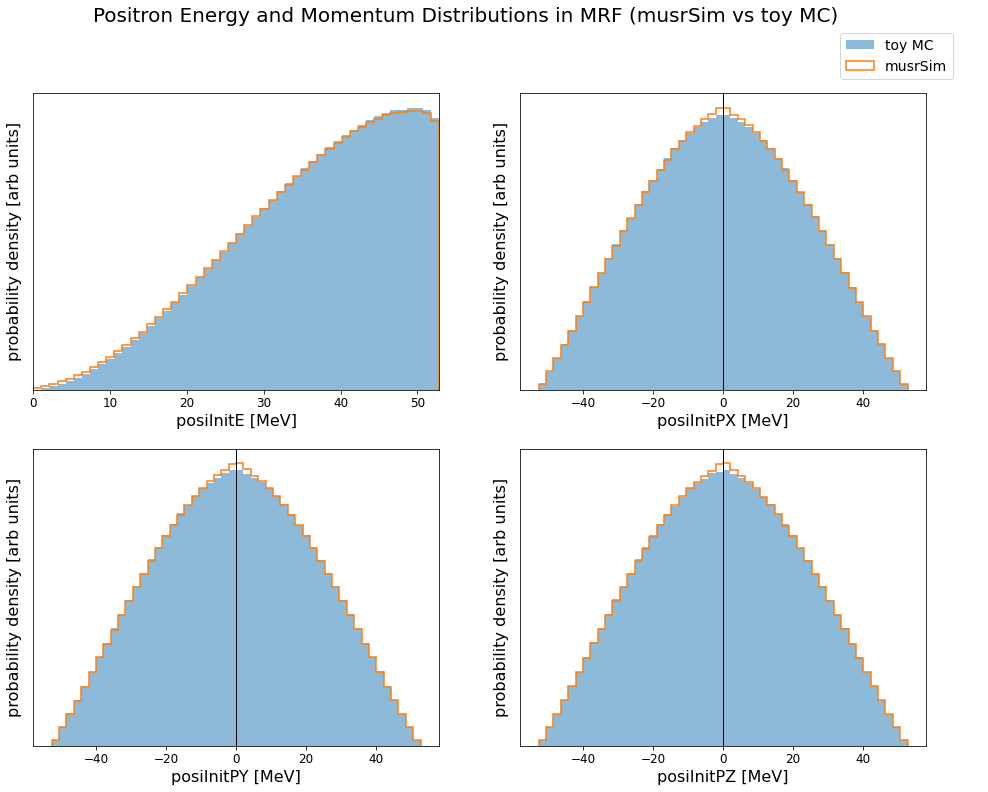

In [13]:
# retrieve histogram bins
mrf_E_mc = hist_dict.get('mrf_E_mc')
mrf_PX_mc = hist_dict.get('mrf_PX_mc')    
mrf_PY_mc = hist_dict.get('mrf_PY_mc')
mrf_PZ_mc = hist_dict.get('mrf_PZ_mc')
mrf_E_musr = hist_dict.get('mrf_E_musr')    
mrf_PX_musr = hist_dict.get('mrf_PX_musr')
mrf_PY_musr = hist_dict.get('mrf_PY_musr')    
mrf_PZ_musr = hist_dict.get('mrf_PZ_musr')


# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in MRF (musrSim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(x=mrf_E_mc[1][:-1],bins=mrf_E_mc[1],weights=mrf_E_mc[0],alpha=0.5,label='toy MC')
ax1.hist(x=mrf_E_musr[1][:-1],bins=mrf_E_musr[1],weights=mrf_E_musr[0],histtype='step',linewidth=1.5,label='musrSim')
ax1.set_xlim([0,52.8])
ax1.set_yticklabels([])
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb units]",fontsize=16)


ax2 = fig.add_subplot(2,2,2)
ax2.hist(x=mrf_PX_mc[1][:-1],bins=mrf_PX_mc[1],weights=mrf_PX_mc[0],alpha=0.5)
ax2.hist(x=mrf_PX_musr[1][:-1],bins=mrf_PX_musr[1],weights=mrf_PX_musr[0],histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', left=False)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb units]",fontsize=16)


ax3 = fig.add_subplot(2,2,3)
ax3.hist(x=mrf_PY_mc[1][:-1],bins=mrf_PY_mc[1],weights=mrf_PY_mc[0],alpha=0.5)
ax3.hist(x=mrf_PY_musr[1][:-1],bins=mrf_PY_musr[1],weights=mrf_PY_musr[0],histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_yticklabels([])
ax3.tick_params(axis='y', left=False)
ax3.tick_params(axis='x', labelsize=12)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb units]",fontsize=16)


ax4 = fig.add_subplot(2,2,4)
ax4.hist(x=mrf_PZ_mc[1][:-1],bins=mrf_PZ_mc[1],weights=mrf_PZ_mc[0],alpha=0.5)
ax4.hist(x=mrf_PZ_musr[1][:-1],bins=mrf_PZ_musr[1],weights=mrf_PZ_musr[0],histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_yticklabels([])
ax4.tick_params(axis='y', left=False)
ax4.tick_params(axis='x', labelsize=12)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb units]",fontsize=16)


fig.legend(loc=(0.85,0.9),fontsize=14)

# 3.1 posiInitE, posiInitPX, posiInitPY, posiInitPZ: toyMC vs gm2ringsim

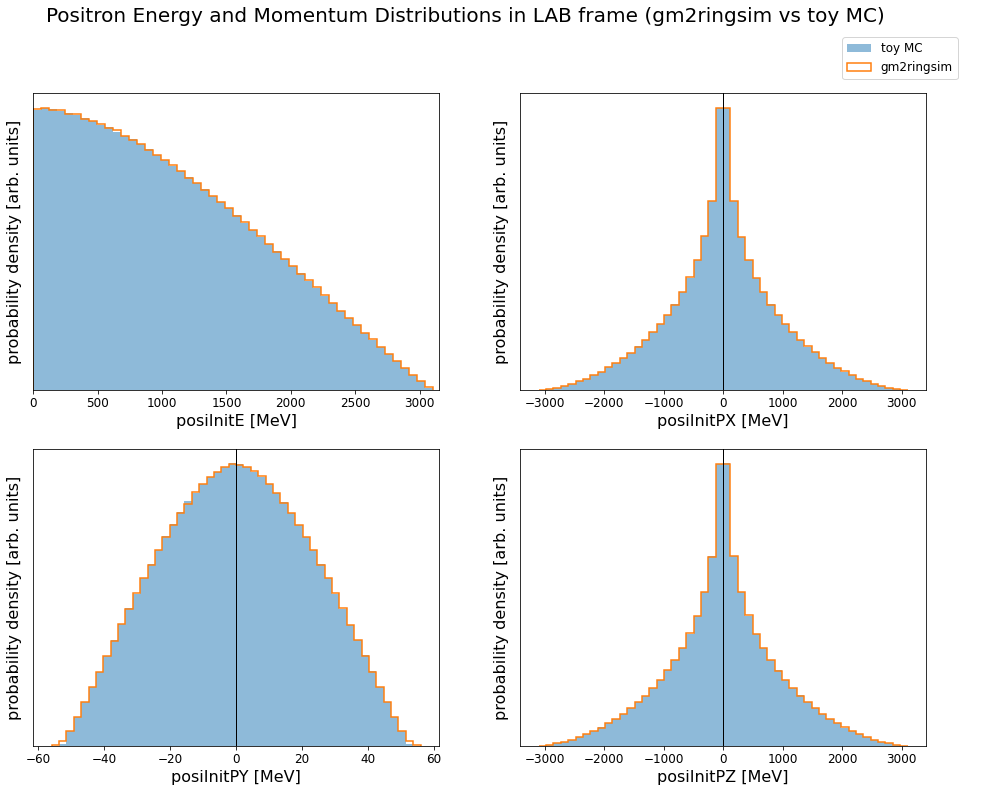

In [14]:
# retrieve histogram bins
E_mc = hist_dict.get('E_mc')
E_gm2ringsim = hist_dict.get('E_gm2ringsim')
PX_mc = hist_dict.get('PX_mc')
PX_gm2ringsim = hist_dict.get('PX_gm2ringsim')
PY_mc = hist_dict.get('PY_mc')
PY_gm2ringsim = hist_dict.get('PY_gm2ringsim')
PZ_mc = hist_dict.get('PZ_mc')
PZ_gm2ringsim = hist_dict.get('PZ_gm2ringsim')


# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in LAB frame (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(x=E_mc[1][:-1],bins=E_mc[1],weights=E_mc[0],alpha=0.5,label='toy MC')
ax1.hist(x=E_gm2ringsim[1][:-1],bins=E_gm2ringsim[1],weights=E_gm2ringsim[0],histtype='step',linewidth=1.5,label='gm2ringsim')
ax1.set_xlim([0,3150])
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

ax2 = fig.add_subplot(2,2,2)
ax2.hist(x=PX_mc[1][:-1],bins=PX_mc[1],weights=PX_mc[0],alpha=0.5)
ax2.hist(x=PX_gm2ringsim[1][:-1],bins=PX_gm2ringsim[1],weights=PX_gm2ringsim[0],histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', left=False)
ax2.set_yticklabels([])

ax3 = fig.add_subplot(2,2,3)
ax3.hist(x=PY_mc[1][:-1],bins=PY_mc[1],weights=PY_mc[0],alpha=0.5)
ax3.hist(x=PY_gm2ringsim[1][:-1],bins=PY_gm2ringsim[1],weights=PY_gm2ringsim[0],histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb. units]",fontsize=16)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', left=False)
ax3.set_yticklabels([])

ax4 = fig.add_subplot(2,2,4)
ax4.hist(x=PZ_mc[1][:-1],bins=PZ_mc[1],weights=PZ_mc[0],alpha=0.5)
ax4.hist(x=PZ_gm2ringsim[1][:-1],bins=PZ_gm2ringsim[1],weights=PZ_gm2ringsim[0],histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb. units]",fontsize=16)
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', left=False)
ax4.set_yticklabels([])


fig.legend(loc=(0.85,0.9),fontsize=12)

# 3.2 posiInitE distribution at different g2 phases

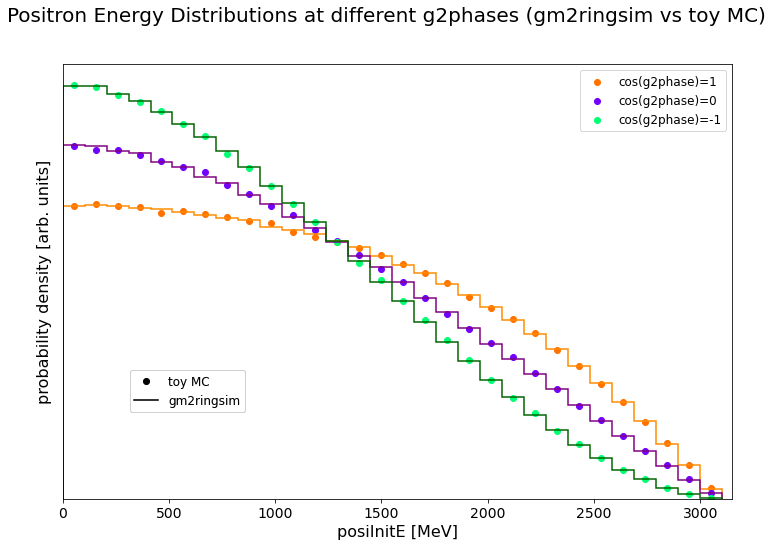

In [15]:
# retrieve histogram bins
cos1_mc = hist_dict.get('cos1_mc')
cos1_gm2ringsim = hist_dict.get('cos1_gm2ringsim')
cos0_mc = hist_dict.get('cos0_mc')
cos0_gm2ringsim = hist_dict.get('cos0_gm2ringsim')
cos_1_mc= hist_dict.get('cos-1_mc')
cos_1_gm2ringsim = hist_dict.get('cos-1_gm2ringsim')


# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positron Energy Distributions at different g2phases (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(x=cos1_gm2ringsim[1][:-1],bins=cos1_gm2ringsim[1],weights=cos1_gm2ringsim[0],color='darkorange',histtype='step',linewidth=1.5)
bin_counts = cos1_mc[0]
bin_edges = cos1_mc[1]
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#FF7200',label='g2phase=0')

ax1.hist(x=cos0_gm2ringsim[1][:-1],bins=cos0_gm2ringsim[1],weights=cos0_gm2ringsim[0],color='purple',histtype='step',linewidth=1.5)
bin_counts = cos0_mc[0]
bin_edges = cos0_mc[1]
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#7200FF',label='g2phase=90')

ax1.hist(x=cos_1_gm2ringsim[1][:-1],bins=cos_1_gm2ringsim[1],weights=cos_1_gm2ringsim[0],color='darkgreen',histtype='step',linewidth=1.5)
bin_counts = cos_1_mc[0]
bin_edges = cos_1_mc[1]
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#00FF72',label='g2phase=180')


ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

lgd1 = ax1.legend(fontsize=12)
ax1.add_artist(lgd1)

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [],linewidth=0, color='black', marker='o', markersize=6, label='toy MC')
line2 = mlines.Line2D([], [],linewidth=1.5, color='black', markersize=8, label='gm2ringsim')
lgd2 = ax1.legend(handles=[line1,line2],fontsize=12,loc=(0.1,0.2))
ax1.add_artist(lgd2)

# 3.3 Energy vs g2phase Distribution

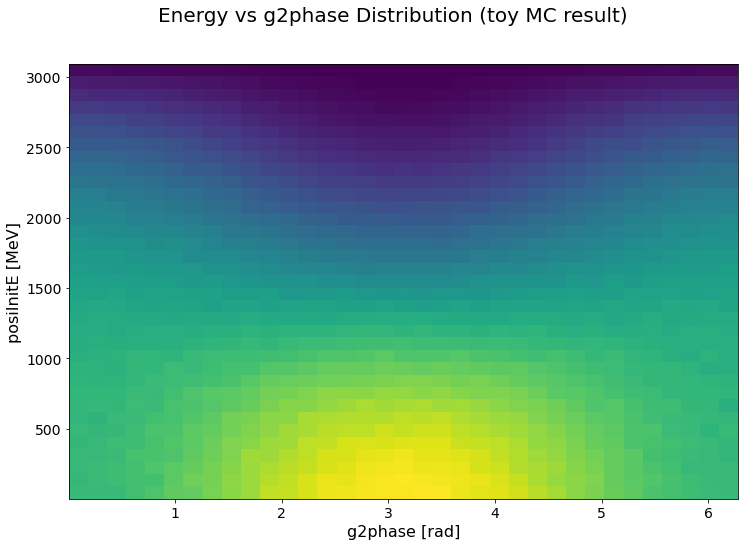

In [16]:
# retrieve histogram bins
phaseVsE_mc = hist_dict.get('phaseVsE_mc')

# plot
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (toy MC result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(phaseVsE_mc[1], phaseVsE_mc[2], phaseVsE_mc[0].T, cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

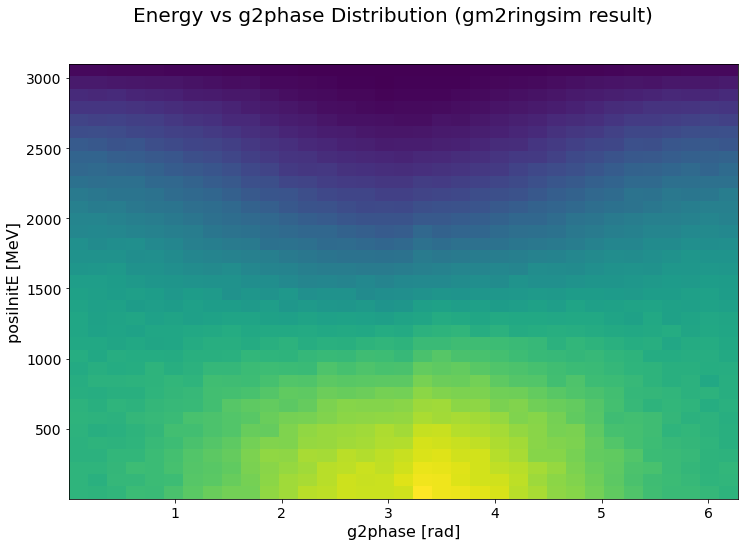

In [17]:
# retrieve histogram bins
phaseVsE_gm2ringsim = hist_dict.get('phaseVsE_gm2ringsim')

# plot
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (gm2ringsim result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(phaseVsE_gm2ringsim[1], phaseVsE_gm2ringsim[2], phaseVsE_gm2ringsim[0].T, cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# 4.0 positron energy distribution (MRF vs LAB) in toyMC: 

# 4.1 positron energy distribution (MRF vs LAB) in toyMC: 2d histogram

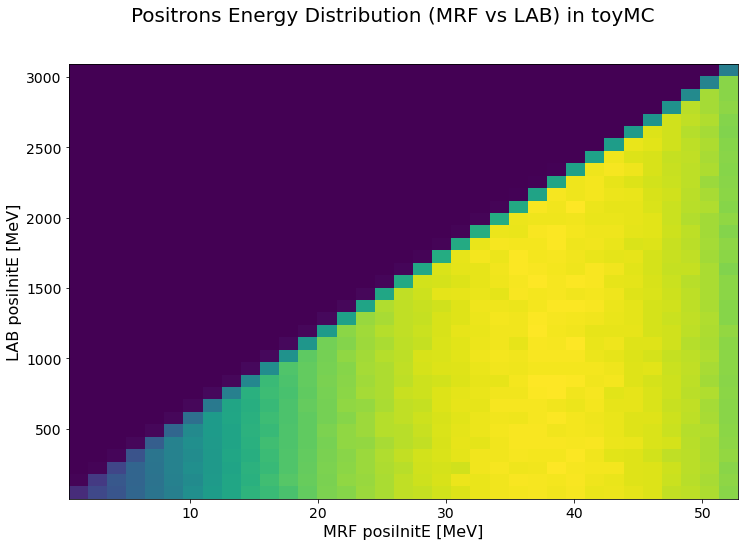

In [18]:
# retrieve histogram bins
E_mrf_v_lab = hist_dict.get('E_mrf_v_lab')

# plot
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution (MRF vs LAB) in toyMC', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(E_mrf_v_lab[1], E_mrf_v_lab[2], E_mrf_v_lab[0].T, cmap='viridis')

ax1.set_xlabel('MRF posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("LAB posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# 4.2 positron energy distribution (LAB) in toyMC (with 1 MeV, 5 MeV, 10 MeV cut in MRF)

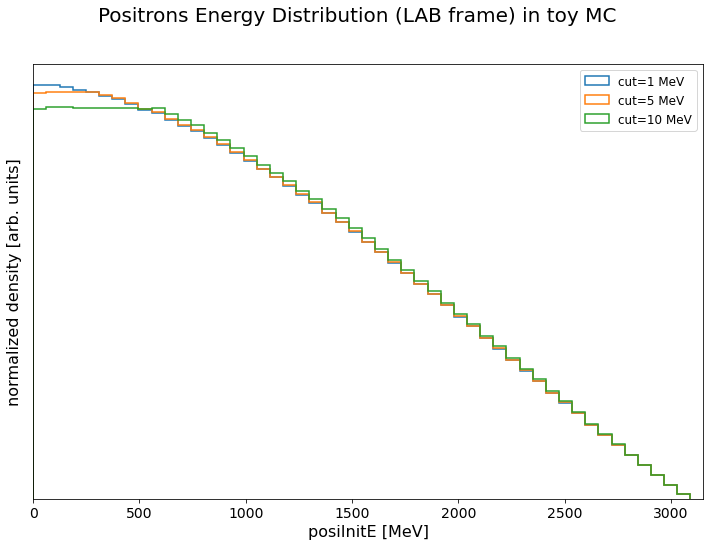

In [19]:
# retrieve histogram bins
Elab_mrfcut_1mev = hist_dict.get('Elab_mrfcut_1mev')
Elab_mrfcut_5mev = hist_dict.get('Elab_mrfcut_5mev')
Elab_mrfcut_10mev = hist_dict.get('Elab_mrfcut_10mev')

# plot
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution (LAB frame) in toy MC', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(x=Elab_mrfcut_1mev[1][:-1],bins=Elab_mrfcut_1mev[1],weights=Elab_mrfcut_1mev[0],histtype='step',linewidth=1.5,label='cut=1 MeV')
ax1.hist(x=Elab_mrfcut_5mev[1][:-1],bins=Elab_mrfcut_5mev[1],weights=Elab_mrfcut_5mev[0],histtype='step',linewidth=1.5,label='cut=5 MeV')
ax1.hist(x=Elab_mrfcut_10mev[1][:-1],bins=Elab_mrfcut_10mev[1],weights=Elab_mrfcut_10mev[0],histtype='step',linewidth=1.5,label='cut=10 MeV')

ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("normalized density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])
ax1.legend(fontsize=12)